In [1]:
from copy import deepcopy
from math import sqrt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.base import clone
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
def lc_plot(estimator, factor_return, size, min_spread=0.001, k_cvs=10):
    '''
    绘制学习曲线，选择合适的训练集大小
    Args:
        factor_return:
            因子排名前50的成分股的日收益率的均值，此外必须包含'spread'数据，才能实现剔除涨跌幅差过小的样本，类别标签在最后一列
        size:
            训练集大小的上限
        min_spread:
            最小的涨跌幅差，表示剔除训练集中涨跌幅差过小的样本的阈值，取值应大于等于0，默认值为0.001
        k_cvs:
            交叉验证的折数
    Return:
        输出一个正确率与训练集大小的变化图
    '''
    train = factor_return.iloc[:size, :]
    if min_spread: # 剔除训练集中涨跌幅差绝对值小于min_spread的样本
        train = train[abs(train['spread']) >= min_spread]
    X_train = train.iloc[:, :-1]
    Y_train = train.iloc[:, -1] 
    X_test = factor_return.iloc[size:, :-1]
    Y_test = factor_return.iloc[size:, -1]
    X_train.drop(labels='spread', axis=1, inplace=True)
    X_test.drop(labels='spread', axis=1, inplace=True)
        
    train_size, train_score, test_score = learning_curve(estimator, X_train, Y_train, 
                                                         train_sizes=np.linspace(0.1, 1, 10), 
                                                         cv=k_cvs, n_jobs=-1)

    plt.plot(train_size, train_score.mean(1), '-bo', label='train accuracy')
    plt.plot(train_size, test_score.mean(1), '--gs', label='test accuray')
    plt.legend()
    plt.xlabel('train size')

In [3]:
class Predict():
    '''
    一个包装了机器学习从数据处理、参数估计到预测效果分析的类
    '''
    
    def __init__(self, estimator, factor_return, size, span, last, min_spread=0.001):
        self.estimator = estimator # 估计器
        self.factor_return = factor_return # 因子收益率
        self.size = size # 训练集大小
        self.span = span # 多少个交易日更新一次模型的参数
        self.last = last # 设定测试数据集的最后几个span
        self.min_spread = min_spread # 最小涨跌幅差
        self.total_size = len(self.factor_return) # 整个数据集的大小
        self.years = (self.total_size - self.size) // self.span + 1 #数据集的span数
        
    def split(self, i):
        '''
        训练集与测试集的分割，类别标签在最后一列
        Args：
            i:
                第几个span
            min_spread:
                最小的涨跌幅差，表示剔除训练集中涨跌幅差过小的样本的阈值，取值应大于等于0，默认值为0.001
        Returns:
            x_train, y_train, x_test, y_test
        '''
        factor_return = self.factor_return
        span = self.span
        size = self.size
        min_spread = self.min_spread
        
        train = factor_return.iloc[i*span : size + i*span, :]
        if min_spread:# 删除训练集中涨跌幅差的绝对值小于min-spread的样本
            train = train[abs(train['spread']) >= min_spread] 
        x_train = train.iloc[:, :-1]
        y_train = train.iloc[:, -1]
        x_test = factor_return.iloc[size + i*span : size + (i+1)*span:, :-1]
        y_test = factor_return.iloc[size + i*span : size + (i+1)*span:, -1]
        x_train.drop(labels='spread', axis=1, inplace=True)
        x_test.drop(labels='spread', axis=1, inplace=True)
        sc = StandardScaler()
        sc.fit(x_train)# 对特征进行标准化
        x_train = sc.transform(x_train) 
        x_test = sc.transform(x_test)
        return x_train, y_train, x_test, y_test

    
    def estimators(self):
        '''
        估计分类器的参数，并保存到一个字典
        '''
        years = self.years
        last = self.last
        ests = {}
        for i in range(years - last, years):
            x_train, y_train, x_test, y_test = self.split(i) # 分割训练集合测试集
            ests[i-(years-last)] =  deepcopy(self.estimator.fit(x_train, y_train))
        
        return ests
    
    def coeficients(self, estimators):
        '''
        获得各个特征在不同时期的影响系数，取绝对值的平均数，返回一个Series
        '''
        names = self.factor_return.columns.tolist()[:-2]
        coefs = pd.concat([pd.Series(estimators[i].coef_[0], index=names).abs() 
                           for i in range(len(estimators))], axis=1).T.mean()
        return coefs
    
    def predicts(self, estimators):
        '''
        预测类别，返回一个DataFrame，含有两列，第一列表示预测的类别'predict'，第二列表示对应的概率'proba'
        '''
        years = self.years
        last = self.last
        predict = defaultdict(dict)
        for i in range(years - last, years):
            x_train, y_train, x_test, y_test = self.split(i)
            est = estimators[i-(years-last)]
            predict[i]['predict'] = est.predict(x_test) # 预测类别
#             predict[i]['proba'] = est.predict_proba(x_test)[:, 1] # 预测的概率
            predict[i]['proba'] = np.where(predict[i]['predict'] == 1, est.predict_proba(x_test)[:, 1],  
                                           est.predict_proba(x_test)[:, 0])# 预测的概率
            predict[i]['datetime'] = y_test.index
        predicts = pd.concat([pd.DataFrame(predict[i]) for i in range(years-last, years)])
        predicts.set_index('datetime', inplace=True)
        return predicts
    
    def trade_records(self, predicts, min_proba=0):
        '''
        根据预测的类别和设定的最小概率的阈值，确定交易
        Args：
            predicts:
                predict方法产生的结果，包含预测的类别标签和对应的概率
            min_proba:
                设定的最小概率的阈值，大于该阈值时才进行交易，一般要大于0.5才会真正起到限制作用
        Returns:
            返回一个交易记录的标签，值为1，-1，0
        '''
        Y_test = self.factor_return.loc[self.factor_return.index[self.size]:, 'hs_zz']
        labels = predicts.join(Y_test)
        # 交易记录，如果概率大于min_proba且类别预测正确，则记录为1，表示获利交易；
        # 如果概率大于min_proba且类别预测错误，则记录为-1，表示亏损交易；
        # 其他记录为0，表示没有交易
        labels['record'] = np.where((labels['proba'] >= min_proba) & 
                                    (labels['hs_zz'] == labels['predict']), 1, 
                                    np.where((labels['proba'] >= min_proba) & 
                                             (labels['hs_zz'] != labels['predict']), -1, 0)) 
        labels['record'] = labels['record'].shift(1) # 将记录移至一个交易日
        labels.dropna(inplace=True)
        return labels.loc[:, ['record', 'proba']]
    
    def confusion(self, predicts):
        '''
        返回混淆矩阵
        '''
        Y_test = self.factor_return.loc[self.factor_return.index[self.size]:, 'hs_zz']# 测试集的实际标签
        labels = predicts.join(Y_test)
        confmat = confusion_matrix(labels['hs_zz'], labels['predict'])
        
        fig, ax = plt.subplots(figsize=(3, 3))
        ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
        for i in range(confmat.shape[0]):
            for j in range(confmat.shape[1]):
                ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

        plt.xlabel('predicted label')
        plt.ylabel('true label')
        
    def scores(self, estimators):
        '''
        计算预测的正确率
        '''
        factor_return = self.factor_return
        size = self.size
        span = self.span
        total_size = self.total_size
        years = self.years
        last = self.last
        
        scores_ = defaultdict(dict)
        for i in range(years - last, years):
            x_train, y_train, x_test, y_test = self.split(i)
            est = estimators[i-(years-last)]        
            begin_idx = size + i*span
            test_begin = factor_return.index[size + i*span].strftime('%Y-%m')
            if size + (i+1)*span <= total_size:
                end_idx = size + (i+1)*span
            else:
                end_idx = total_size - 1
            test_end = factor_return.index[end_idx].strftime('%Y-%m')
            scores_[(test_begin, test_end)]['train'] = est.score(x_train, y_train)
            scores_[(test_begin, test_end)]['test'] = est.score(x_test, y_test)
        return scores_
    
    def roc_plot(self, estimators, pos_label=1):
        '''
        绘制ROC曲线
        '''
        years = self.years
        last = self.last
        plt.figure(figsize=(8, 6))
        for i in range(years - last, years):
            x_train, y_train, x_test, y_test = self.split(i)
            est = estimators[i-(years-last)]
            fpr, tpr, _ = roc_curve(y_test, est.decision_function(x_test), pos_label=pos_label)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label='%s span, area = %.2f' % (i-(years-last), roc_auc))
        
            if i == years - 1:
                plt.plot([0, 1], [0, 1], linestyle='--', marker='o', 
                         color='black', label='random guessing')
                plt.legend()

In [4]:
def maxdd(nav):
    '''
    根据净值序列计算最大回撤序列
    '''
    DD = []
    for i in range(1, len(nav)):
        max_i = max(nav[:i+1])
        DD.append((nav[i] - max_i) / max_i)
    return pd.Series(DD, index=nav.index[1:], name='max drawdown')

def scores_plot(scores):
    '''
    绘制预测正确率的变化图
    '''
    scores = pd.DataFrame(scores).T
    scores.index.names = ['begin', 'end']
    scores = scores.loc[:, ['train', 'test']]
    plt.figure(figsize=(8, 6))
    scores.plot(marker='o')
    plt.xlabel('begin end')
    plt.ylabel('accuracy')

In [5]:
def get_nav(record, retn, trans_cost=0, slippage=0):
    '''
    计算净值
    '''
    test_retn = pd.concat([record, retn], axis=1, join='inner')
    if slippage:
        trans_cost += slippage # 将滑点算入交易成本
    # 交易收益等于交易记录标签与实际收益率的乘积
    test_retn['l_s'] = np.where(test_retn['record'] != 0, 
                                test_retn['record'] * abs(test_retn[retn.name]) - trans_cost, 0) 
    test_retn['nav'] = test_retn['l_s'].cumsum() + 1 # 累计收益率
#     test_retn['nav'] = (1 + test_retn['l_s']).cumprod() # 累乘
    return test_retn#['nav']

def evaluate(nav, year_days=242):
    '''
    计算最大回撤，年化收益率，calmar比率等评价指标
    '''
    mdd = maxdd(nav.nav) # 最大回撤
    nav['duration'] = 0
    duration_idx = nav.columns.tolist().index('duration')
    #计算最长回撤期
    for i in range(1, len(nav)):
        if mdd[i-1] == 0:
            nav.iloc[i, duration_idx] = 0
        else:
            nav.iloc[i, duration_idx] = nav.iloc[i-1, duration_idx] + 1
    ann = (nav.nav[-1] / nav.nav[0]) ** (year_days / len(nav)) - 1 # 年化收益率
    calmar = abs(ann / mdd.min()) # calmar比率
    nav['e'] = (nav.l_s - (0.03 / year_days))
    sharpe = nav.e.mean() / nav.e.std() * sqrt(year_days) # 夏普比率
    win = len(nav[nav['l_s'] > 0]) / len(nav[nav['l_s'] != 0]) # 胜率 净收益为正的交易比率
    return nav['duration'].max(), mdd, ann, calmar, sharpe, win

def nav_plot(nav, min_spread=0, min_proba=0, trans_cost=0):
    '''
    绘制回测曲线图
    '''
    mddd, mdd, ann, calmar, sharpe, win = evaluate(nav)
    ddd_idx = nav['duration'].idxmax()
    ddd_begin = nav.loc[:ddd_idx, 'nav'].idxmax()
    ddd_center = nav.index[(len(nav.loc[:ddd_begin, :]) + len(nav.loc[:ddd_idx, :])) // 2]
    dd_idx = mdd.idxmin()
    dd_begin = nav.loc[:dd_idx, 'nav'].idxmax()
    fig, ax = plt.subplots(figsize=(15, 6))
    idx = nav.index
    ax.plot(idx, nav.nav)
    ax.set_xlim(idx[0], idx[-1])
    ax.set_ylabel('Net Aseet Value')
    offset = (nav.nav.max() - nav.nav.min()) / 20
    ax.annotate("", xy=(ddd_idx, nav.nav[ddd_begin]), xycoords='data',
                 xytext=(ddd_begin, nav.nav[ddd_begin]), textcoords='data',
                 arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"))
    ax.text(ddd_center, nav.nav[ddd_begin]+offset, 'max drawdown duration', 
            {'color': 'k', 'fontsize': 12, 'ha': 'center', 'va': 'top',})
    ax.annotate("", xy=(dd_idx, nav.nav[dd_begin]), xycoords='data', 
                xytext=(dd_idx, nav.nav[dd_idx]), textcoords='data',
                arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"))
    ax.text(dd_idx, nav.nav[dd_idx]-offset, 'max drawdown',
            {'color': 'k', 'fontsize': 12, 'ha': 'center', 'va': 'bottom',})
    ax2 = ax.twinx()
    ax2.set_ylim(-1, 0)
    ax2.plot(mdd, color='c')
    ax2.fill_between(mdd.index, mdd, color='c')
    ax2.set_ylabel('Max Drawdown')
    ax2.text(ax2.get_xbound()[0]+10, -0.98, 
             '''trans_cost: %.4f, min_proba: %.4f, Max Drawdwon Duration: %d, Max Drawdown: %.2f%%, Annual: %.2f%%, Calmar: %.2f, sharpe: %.2f, win: %.2f''' % 
             (trans_cost, min_proba, mddd, mdd.min() *100, ann*100, calmar, sharpe, win))

In [6]:
with pd.HDFStore('E:/data/hs_zz.h5') as store:
    print(store.info())
    hs_zz = store['hs_zz']
    factor_return_top = store['factor_return_top']
    factor_return_bottom = store['factor_return_bottom']

<class 'pandas.io.pytables.HDFStore'>
File path: E:/data/hs_zz.h5
/factor_data                     frame        (shape->[5775034,14])
/factor_return_bottom            frame        (shape->[2867,11])   
/factor_return_top               frame        (shape->[2867,17])   
/hs_zz                           frame        (shape->[2888,8])    
/zz800s                          frame        (shape->[3685743,8]) 


In [7]:
factor_return_ = factor_return_top.join(factor_return_bottom, lsuffix='_top', rsuffix='_bottom')

In [8]:
factor_return_ = factor_return_.join(hs_zz.loc[:, ['spread', 'hs_zz']], how='inner')
factor_return_['spread_'] = factor_return_['spread']#.shift(1)
factor_return_.dropna(inplace=True)
# factor_return_.columns.tolist()

In [9]:
positive_factors = ['roe_ttm', 'ebit2ev', 'ep_ttm', 'roegrowth2', 'bp_lr']
select = ['high_1m','low_1m', 'momentum_12m', 'volume', 'amplitude', 'volatility', 
          'lnfloatmktcap', 'volatilityreg', 'weeklyreturn']
select_top = [name+'_top' for name in select]
select_bottom = [name+'_bottom' for name in select]
select_ = select_bottom + positive_factors + ['spread_', 'spread', 'hs_zz'] 
# 只包含bottom和基本面因子，只考虑反转效应
factor_return = factor_return_.loc[:, select_]

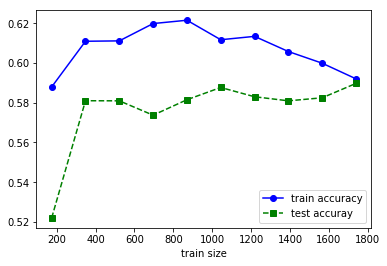

In [10]:
size = 3000
span = 250
last = 3
begin = last*span + size
pipe_lg = Pipeline([('sc', StandardScaler()), ('lg', LogisticRegression(class_weight='balanced', random_state=0))])
fr = factor_return.iloc[-begin:, :]
lc_plot(pipe_lg, fr, size, min_spread=0.003) # 画学习曲线

In [11]:
lg = LogisticRegressionCV(cv=10, class_weight='balanced', n_jobs=-1) 

In [12]:
len(factor_return[abs(factor_return['spread']) > 0.001]) / len(factor_return)

0.8876482903000698

In [13]:
sizes = [1000, 1200]
spans = [150, 200, 250]
min_spreads = [0.001, 0.002, 0.005]

In [14]:
gs = {}
for size in sizes:
    for span in spans:
        for ms in min_spreads:
            print(size, span, ms)
            last = (len(factor_return) - size) // span + 1
            p = Predict(lg, factor_return, size=size, span=span, last=3, min_spread=ms)
            ests = p.estimators()
            predicts = p.predicts(ests)
            records = p.trade_records(predicts, min_proba=0.5)
            nav = get_nav(records, factor_return['spread'], trans_cost=0.0005)
            mddd, mdd, ann, calmar, sharpe, win = evaluate(nav)
            gs[(size, span, ms)] = [mddd, mdd.min(), ann, calmar, sharpe, win]

1000 150 0.001
1000 150 0.002
1000 150 0.005
1000 200 0.001
1000 200 0.002
1000 200 0.005
1000 250 0.001
1000 250 0.002
1000 250 0.005
1200 150 0.001
1200 150 0.002
1200 150 0.005
1200 200 0.001
1200 200 0.002
1200 200 0.005
1200 250 0.001
1200 250 0.002
1200 250 0.005


In [15]:
gs = pd.DataFrame(gs).T
gs.columns = ['mddd', 'mdd', 'ann', 'calmar', 'sharpe', 'win']

In [16]:
gs

mddd       mdd       ann    calmar    sharpe       win
1000 150 0.001  162.0 -0.090232  0.149291  1.654521  0.977492  0.534247
         0.002  202.0 -0.108614  0.102799  0.946463  0.591936  0.523288
         0.005  253.0 -0.165032  0.049388  0.299261  0.162056  0.515068
     200 0.001  167.0 -0.091942  0.144965  1.576693  1.059485  0.537634
         0.002  202.0 -0.100784  0.111080  1.102159  0.742332  0.526882
         0.005  252.0 -0.120276  0.081260  0.675614  0.472054  0.520430
     250 0.001  229.0 -0.099035  0.085900  0.867365  0.542257  0.515447
         0.002  288.0 -0.107198  0.066299  0.618476  0.350730  0.508943
         0.005  525.0 -0.191768  0.022466  0.117154 -0.056556  0.499187
1200 150 0.001  140.0 -0.099351  0.161456  1.625101  0.997645  0.526984
         0.002  197.0 -0.137654  0.081547  0.592404  0.342809  0.514286
         0.005  223.0 -0.176985  0.012427  0.070213 -0.207129  0.498413
     200 0.001  164.0 -0.091531  0.137669  1.504070  0.990271  0.535484
         0.002  162.0 -0.083517  0.147948  1.771476  1.087936  0.539785
         0.005  352.0 -0.185018  0.046819  0.253051  0.169727  0.516129
     250 0.001  563.0 -0.248215  0.020959  0.084438 -0.053820  0.505263
         0.002  606.0 -0.294166  0.002583  0.008780 -0.208620  0.500752
         0.005  664.0 -0.364381 -0.070038  0.192210 -0.772059  0.493233

In [17]:
gs_ = gs[(gs['ann'] > 0.05) & (gs['calmar'] > 0.5)] # 年化大于10%，前calmar大于1的参数，年化也可以设置为大于5%
best_paras = gs_['calmar'].idxmax() # 满足上述条件时，calmar最大的参数
print(gs_.loc[best_paras, :])

mddd      162.000000
mdd        -0.083517
ann         0.147948
calmar      1.771476
sharpe      1.087936
win         0.539785
Name: (1200, 200, 0.002), dtype: float64


In [18]:
best_paras2 = gs_['sharpe'].idxmax() # 满足上述条件时，calmar最大的参数
print(gs_.loc[best_paras2, :])

mddd      162.000000
mdd        -0.083517
ann         0.147948
calmar      1.771476
sharpe      1.087936
win         0.539785
Name: (1200, 200, 0.002), dtype: float64


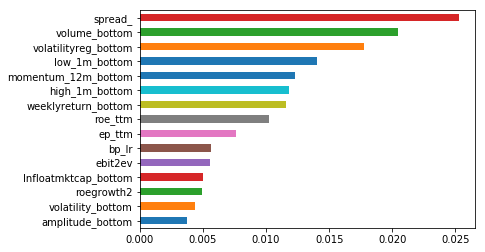

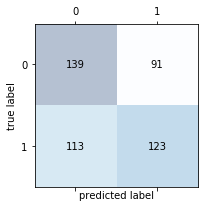

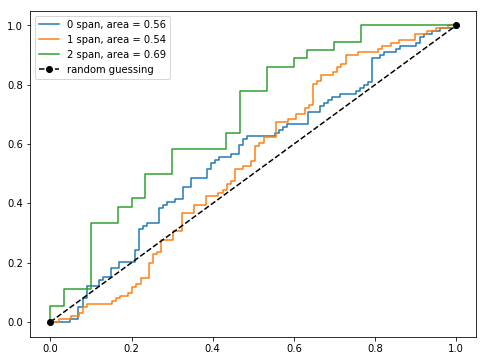

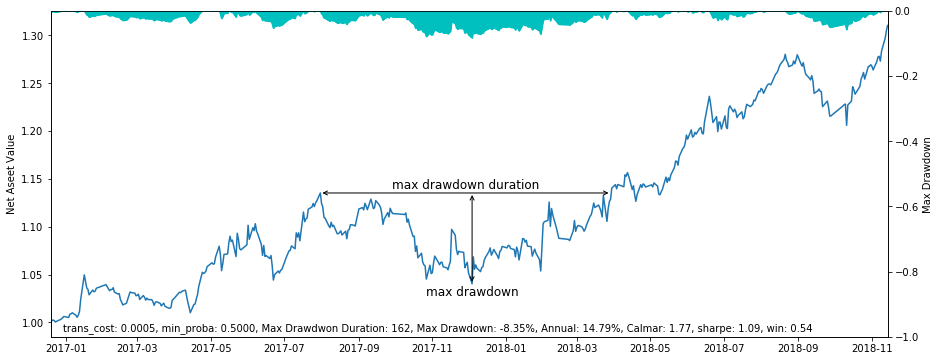

In [19]:
# 按照最优的参数拟合的模型
size, span, ms = best_paras2
p = Predict(lg, factor_return, size=size, span=span, last=3, min_spread=ms) 
ests = p.estimators()
coefs = p.coeficients(ests)
coefs.sort_values().plot(kind='barh')
predicts = p.predicts(ests)
p.confusion(predicts)
scores = p.scores(ests)
p.roc_plot(ests)
records = p.trade_records(predicts, min_proba=0.5)
nav = get_nav(records, factor_return['spread'], trans_cost=0.0005)
nav_plot(nav, min_spread=ms, min_proba=0.5, trans_cost=0.0005)